In [1]:
!nrnivmodl /home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod
from neuron import h
import plotly.graph_objects as go
import matplotlib.colors as mcolors
from neuron.units import ms, mV
import plotly.io as pio
from matplotlib import pyplot, cm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
from neuron import clear_gui_callback
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from numpy.linalg import pinv, eig
import numpy as np
from multiprocessing import Pool
font2={'family':'Times New Roman',
'weight':'bold',
'size': 10}
# 自定义刻度标签显示格式


h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/morphologies/cell1.asc"
biophysicalModelFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCbiophys1.hoc"
biophysicalModelTemplateFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCtemplate.hoc"

h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)
import sys
sys.path.append('/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron')
from common_function import exp_fitting, plot_curve

/home/wzl/anaconda/envs/neuron9/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
INFO : Using neuron-nightly Package (Developer Version)
/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron
cfiles =
Mod files: "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/CaDynamics_E2.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_HVA.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_LVAst.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/epsp.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ih.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Im.mod" "/home/wzl/LFPy/project/conductance_measurement/real

--No graphics will be displayed.


In [2]:
def eff_cond_est_multiple(run_dt, C, GL, fE, fI, locationE, locationI, locnumE, locnumI, fre_stim =100, passive = False, 
                          block='',name= ''):
    
    L5PC = h.L5PCtemplate(morphologyFilename)
    
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.   
    
    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0.)
        
    h.dt = run_dt
    h.tstop = 1300.
    if passive:
        h.v_init = -90.
        Vclamp_init = -90.
    else:
        h.v_init = -76.3
        Vclamp_init = -76.3
    recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
    
    # Initialize an excitatory and inhibitory synaptic input
    # make a new stimulator
    stimEs =[]
    synEs = []
    ncstimEs = []
    stimIs =[]
    synIs = []
    ncstimIs = []

    for i in range(len(locnumE)):
        stimE = h.NetStim()
        stimE.number = int(fre_stim)
        stimE.start = 300.  # ms
        if locationE[i] == 'dend':
            synE = h.Exp2Syn(L5PC.dend[int(locnumE[i])](0.9))
        if locationE[i] == 'apic':
            synE = h.Exp2Syn(L5PC.apic[int(locnumE[i])](0.9))
        if locationE[i] == 'soma':
            synE = h.Exp2Syn(L5PC.soma[0](0.5))
        synE.tau1 = 1.  # ms
        synE.tau2 = 5.  # ms
        if passive:
            synE.e = 0.
        else:
            synE.e = 13.7  # mV for E input and -100 for I input 
        
        ncstimE = h.NetCon(stimE, synE)
        ncstimE.delay = 0.
        ncstimE.weight[0] = 0e-2  # uS
        stimEs.append(stimE)
        synEs.append(synE)
        ncstimEs.append(ncstimE)
    
    for i in range(len(locnumI)):
        stimI = h.NetStim()
        stimI.number = int(fre_stim)
        stimI.start = 300.
        if locationI[i] == 'dend':
            synI = h.Exp2Syn(L5PC.dend[int(locnumI[i])](0.9))
        if locationI[i] == 'apic':
            synI = h.Exp2Syn(L5PC.apic[int(locnumI[i])](0.9))
        if locationI[i] == 'soma':
            synI = h.Exp2Syn(L5PC.soma[0](0.5))
        synI.tau1 = 1.  # ms
        synI.tau2 = 5.  # ms
        if passive:
            synI.e = -100.
        else:
            synI.e = -86.3
        ncstimI = h.NetCon(stimI, synI)
        ncstimI.delay = 0.
        ncstimI.weight[0] = 0e-2  # uS
        stimIs.append(stimI)
        synIs.append(synI)
        ncstimIs.append(ncstimI)
    
    i_loc =h.Vector().record(synEs[0]._ref_i)

    # Initialize voltage clamp
    vclamp = h.SEClamp(L5PC.soma[0](0.5))
    vclamp.amp1 = Vclamp_init
    vclamp.dur1 = h.tstop
    vclamp.dur2 = h.tstop
    vclamp.amp2 = Vclamp_init - 20.

    irec = h.Vector()
    irec.record(vclamp._ref_i)

    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()

    # Main simulation loop
    def main():

        Vclamp = np.arange(-110.,-60.,10)
        vclamp.dur1 = 0.
        vclamp.dur2 = 0.
        vclamp.dur3 = 0.
        go()
        recv0 = np.array(recv.to_python())
        V_rest = recv0[-1]
        # V_rest = -76.4
        print(V_rest)
        epsilonE = 13.7 - V_rest
        epsilonI = -86.3 - V_rest
        epsilonI1 = -106.3 - V_rest
        
        #  pure E input for the estimation of GE
        for i in range(len(locnumE)):
            ncstimEs[i].weight[0] = fE
            synEs[i].e = 13.7
        vclamp.dur1 = 0.
        vclamp.dur2 = 0.
        vclamp.dur3 = 0.
        go()
        recv0 = np.array(recv.to_python())
        recv0_norm = recv0 - V_rest
        dVdt = np.diff(recv0_norm)/run_dt
        dVdt = np.append(dVdt, 0)
        GE_est = (C*dVdt + GL*recv0_norm)/(epsilonE - recv0_norm)
        i_loc0 = np.array(i_loc.to_python())
        plt.plot(i_loc0, 'k',label='pure E')
        
        
        
        #  pure I input for estimation of GI
        for i in range(len(locnumI)):
            ncstimIs[i].weight[0] = fI
            synIs[i].e = -86.3
        vclamp.dur1 = 0.
        vclamp.dur2 = 0.
        vclamp.dur3 = 0.
        go()
        recv0 = np.array(recv.to_python())
        recv0_norm = recv0 - V_rest
        dVdt = np.diff(recv0_norm)/run_dt
        dVdt = np.append(dVdt, 0)
        GI_est = (C*dVdt + GL*recv0_norm)/(epsilonI - recv0_norm)

        
        
    
        Isyn_inj_t = np.zeros((len(Vclamp),1000))
        Isyn_epsilonI1_inj_t = np.zeros((len(Vclamp),1000))
        tstart = int(300/run_dt+1)
        

        for i in range(len(Vclamp)):
            
            vclamp.amp1 = Vclamp[i]
            vclamp.dur1 = h.tstop
            h.v_init = V_rest
            go()
            Iinj0 = np.array(irec.to_python())  # Assuming irec is a NEURON Vector
            i_loc0 = np.array(i_loc.to_python())
            
            for j in range(len(locnumE)):
                ncstimEs[j].weight[0] = fE
            for j in range(len(locnumI)):
                ncstimIs[j].weight[0] = fI
            vclamp.amp1 = Vclamp[i]
            vclamp.dur1 = h.tstop
            h.v_init = V_rest
            go()
            i_loc0 = np.array(i_loc.to_python())
            plt.plot(i_loc0, label='E,I voltage clamp')
            Iinj1 = np.array(irec.to_python())  # Assuming irec is a NEURON Vector
            Isyn = (Iinj1[tstart:tstart+1000] - Iinj0[tstart:tstart+1000])
            Isyn_inj_t[i,:] = Isyn
            
            
            for j in range(len(locnumI)):
                synIs[j].e = -106.3
                ncstimIs[j].weight[0] = fI
            for j in range(len(locnumE)):
                ncstimEs[j].weight[0] = fE  
                    
            vclamp.amp1 = Vclamp[i]
            vclamp.dur1 = h.tstop
            h.v_init = V_rest
            go()
            Iinj1_epsilonI1 = np.array(irec.to_python())  # Assuming irec is a NEURON Vector
            Isyn_epsilonI1 =  (Iinj1_epsilonI1[tstart:tstart+1000] - Iinj0[tstart:tstart+1000])
            Isyn_epsilonI1_inj_t[i,:] = Isyn_epsilonI1
        
        plt.legend()
            
                                                         
        traditional_effective_conductance = np.zeros((2,1000))
        intercept_effective_conductance = np.zeros((2,1000))
        A = np.ones((len(Vclamp),2))
        A[:,0] = Vclamp - V_rest
        for i in range(1000):
            x, residuals, rank, singular_values = np.linalg.lstsq(A, Isyn_inj_t[:,i], 
                                                                  rcond=None)
            x_epsilonI1, residuals, rank, singular_values = np.linalg.lstsq(A, 
                                Isyn_epsilonI1_inj_t[:,i], rcond=None)
            
            traditional_effective_conductance[1, i] = (x[0]*epsilonE + x[1])/(epsilonE - epsilonI)
            traditional_effective_conductance[0, i] = (x[0]*epsilonI + x[1])/(epsilonI - epsilonE)
           
            intercept_effective_conductance[1,i] = (x[1] - x_epsilonI1[1])/(epsilonI1 - epsilonI)
            intercept_effective_conductance[0,i] = (-intercept_effective_conductance[1,i]*epsilonI - x[1])/epsilonE
            
        
        return intercept_effective_conductance, traditional_effective_conductance, GE_est, GI_est
    
    
    intercept_effective_conductance, traditional_effective_conductance, GE_est, GI_est = main()
    return intercept_effective_conductance, traditional_effective_conductance, GE_est, GI_est

In [3]:
def generate_spike_time(tstart, num_stim, fre_stim):
    spike_time = []
    np.random.seed(123)
    # 生成泊松分布随机数，表示事件发生的次数
    for i in range(num_stim):
        poisson_counts = np.random.poisson(1000./fre_stim, fre_stim)
        # 生成事件发生的时间
        poisson_time = np.cumsum(poisson_counts)
        poisson_time = poisson_time + tstart
        spike_time = np.append(spike_time,poisson_time)
    return spike_time

In [14]:
locationE0 = ['dend']
locationE0 = np.repeat(locationE0,80)
locationI0 = ['apic']
locationI0 = np.repeat(locationI0,20)
locnumE0 = np.random.randint(0, 84,80)
locnumI0 =np.random.randint(0, 109,20)
fre_stim = 40
tstart = 600
Estart = generate_spike_time(tstart, len(locnumE0), fre_stim)
Istart = generate_spike_time(tstart, len(locnumI0), fre_stim)
locnumE = np.repeat(locnumE0, fre_stim)
locnumI = np.repeat(locnumI0, fre_stim)
locationE = np.repeat(locationE0, fre_stim)
locationI = np.repeat(locationI0, fre_stim)
# print(Estart)
# print(len(locnumE))
print(Estart[:80])

[ 628.  649.  677.  702.  725.  749.  772.  792.  817.  844.  872.  900.
  923.  945.  962.  986. 1010. 1034. 1069. 1096. 1118. 1149. 1174. 1192.
 1218. 1241. 1265. 1297. 1325. 1352. 1383. 1412. 1432. 1459. 1485. 1504.
 1526. 1552. 1575. 1597.  623.  649.  668.  689.  714.  732.  754.  785.
  816.  838.  860.  886.  919.  941.  962.  992. 1021. 1047. 1071. 1095.
 1112. 1146. 1170. 1199. 1227. 1246. 1268. 1295. 1322. 1350. 1374. 1400.
 1426. 1455. 1484. 1517. 1533. 1556. 1582. 1602.]


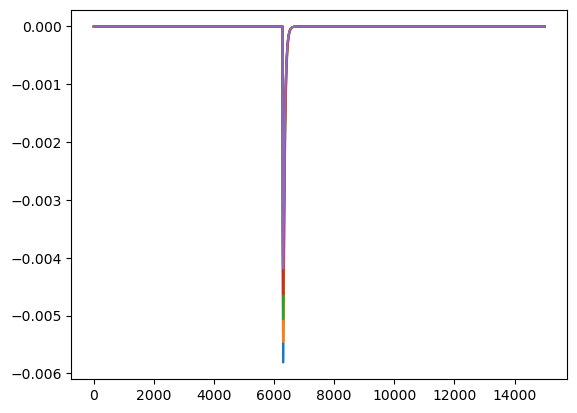

In [5]:
locationE0 = ['dend']
locationE0 = np.repeat(locationE0,80)
locationI0 = ['apic']
locationI0 = np.repeat(locationI0,20)
locnumE0 = np.random.randint(0, 84,80)
locnumI0 =np.random.randint(0, 109,20)
fre_stim = 40
tstart = 600
Estart = generate_spike_time(tstart, len(locnumE0), fre_stim)
Istart = generate_spike_time(tstart, len(locnumI0), fre_stim)
locnumE = np.repeat(locnumE0, fre_stim)
locnumI = np.repeat(locnumI0, fre_stim)
locationE = np.repeat(locationE0, fre_stim)
locationI = np.repeat(locationI0, fre_stim)


C=0.00024
GL = 1.93e-05
run_dt = 0.1 
fE = 0.5e-4
fI = 3e-4 
passive = False

                        

L5PC = h.L5PCtemplate(morphologyFilename)

if passive:
    for sec in h.allsec():
        # 检查 section 是否有主动离子通道
        if h.ismembrane("na3", sec=sec):
            # 将电导设置为0
            sec.gbar_na3 = 0.
        if h.ismembrane("h", sec=sec):
            sec.ghdbar_h = 0.
        if h.ismembrane("kadist", sec=sec):
            sec.gkabar_kadist = 0.
        if h.ismembrane("kaprox", sec=sec):
            sec.gkabar_kaprox = 0.
        if h.ismembrane("kdrca1", sec=sec):
            sec.gkdrbar_kdrca1 = 0.
        if h.ismembrane("nax", sec=sec):
            sec.gbar_nax = 0.
        if h.ismembrane("Ca_HVA",sec=sec):
            sec.gCa_HVAbar_Ca_HVA = 0.
        if h.ismembrane("Ca_LVAst",sec=sec):
            sec.gCa_LVAstbar_Ca_LVAst = 0.
        if h.ismembrane("Ih",sec=sec):
            sec.gIhbar_Ih = 0.
        if h.ismembrane("Im",sec=sec):
            sec.gImbar_Im = 0.
        if h.ismembrane("K_Pst",sec=sec):
            sec.gK_Pstbar_K_Pst = 0.
        if h.ismembrane("K_Tst",sec=sec):
            sec.gK_Tstbar_K_Tst = 0.
        if h.ismembrane("Nap_Et2",sec=sec):
            sec.gNap_Et2bar_Nap_Et2 = 0.
        if h.ismembrane("NaTa_t",sec=sec):
            sec.gNaTa_tbar_NaTa_t = 0.
        if h.ismembrane("NaTs2_t",sec=sec):
            sec.gNaTs2_tbar_NaTs2_t = 0.
        if h.ismembrane("SK_E2",sec=sec):
            sec.gSK_E2bar_SK_E2 = 0.
        if h.ismembrane("SKv3_1",sec=sec):
            sec.gSKv3_1bar_SKv3_1 = 0.   
    
h.dt = run_dt
h.tstop = 1500.
if passive:
    h.v_init = -90.
    Vclamp_init = -90.
else:
    h.v_init = -76.3
    Vclamp_init = -76.3
recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)

# Initialize an excitatory and inhibitory synaptic input
# make a new stimulator
stimEs =[]
synEs = []
ncstimEs = []
stimIs =[]
synIs = []
ncstimIs = []

for i in range(len(locnumE)):
    stimE = h.NetStim()
    stimE.number = 1
    stimE.start = Estart[i]  # ms
    if locationE[i] == 'dend':
        synE = h.Exp2Syn(L5PC.dend[int(locnumE[i])](0.5))
    if locationE[i] == 'apic':
        synE = h.Exp2Syn(L5PC.apic[int(locnumE[i])](0.5))
    if locationE[i] == 'soma':
        synE = h.Exp2Syn(L5PC.soma[0](0.5))
    synE.tau1 = 1.  # ms
    synE.tau2 = 5.  # ms
    synE.e = 13.7
    ncstimE = h.NetCon(stimE, synE)
    ncstimE.delay = 0.
    ncstimE.weight[0] = 0e-2  # uS
    stimEs.append(stimE)
    synEs.append(synE)
    ncstimEs.append(ncstimE)

for i in range(len(locnumI)):
    stimI = h.NetStim()
    stimI.number = 1
    stimI.start = Istart[i]
    if locationI[i] == 'dend':
        synI = h.Exp2Syn(L5PC.dend[int(locnumI[i])](0.5))
    if locationI[i] == 'apic':
        synI = h.Exp2Syn(L5PC.apic[int(locnumI[i])](0.5))
    if locationI[i] == 'soma':
        synI = h.Exp2Syn(L5PC.soma[0](0.5))
    synI.tau1 = 1.  # ms
    synI.tau2 = 5.  # ms

    synI.e = -86.3
    ncstimI = h.NetCon(stimI, synI)
    ncstimI.delay = 0.
    ncstimI.weight[0] = 0e-2  # uS
    stimIs.append(stimI)
    synIs.append(synI)
    ncstimIs.append(ncstimI)

i_loc =h.Vector().record(synEs[0]._ref_i)

# Initialize voltage clamp
vclamp = h.SEClamp(L5PC.soma[0](0.5))
vclamp.amp1 = Vclamp_init
vclamp.dur1 = h.tstop
vclamp.dur2 = h.tstop
vclamp.amp2 = Vclamp_init - 20.

irec = h.Vector()
irec.record(vclamp._ref_i)

# Function to initialize the simulation
def initialize():
    h.t = 0
    h.finitialize(h.v_init)
    h.fcurrent()

# Function to integrate the simulation
def integrate():
    while h.t < h.tstop:
        h.fadvance()

# Function to run the simulation
def go():
    initialize()
    integrate()

V_rest = -76.3
epsilonE = 13.7 - V_rest
epsilonI = -86.3 - V_rest
epsilonI1 = -106.3 - V_rest

#  pure E input for the estimation of GE
for i in range(len(locnumE)):
    ncstimEs[i].weight[0] = fE
    synEs[i].e = 13.7
for i in range(len(locnumI)):
    ncstimIs[i].weight[0] = 0.
    synIs[i].e = -86.3
vclamp.dur1 = 0.
vclamp.dur2 = 0.
vclamp.dur3 = 0.
go()
recvE0 = np.array(recv.to_python())
recvE0_norm = recvE0[int(tstart/run_dt):] - V_rest
dVdtE = np.diff(recvE0_norm)/run_dt
dVdtE = np.append(dVdtE, 0)
GE_est = (C*dVdtE + GL*recvE0_norm)/(epsilonE - recvE0_norm)
i_loc0 = np.array(i_loc.to_python())
plt.plot(i_loc0, 'k',label='pure E')



#  pure I input for estimation of GI
for i in range(len(locnumE)):
    ncstimEs[i].weight[0] = 0.
    synEs[i].e = 13.7
for i in range(len(locnumI)):
    ncstimIs[i].weight[0] = fI
    synIs[i].e =  -86.3
vclamp.dur1 = 0.
vclamp.dur2 = 0.
vclamp.dur3 = 0.
go()
recvI0 = np.array(recv.to_python())
i_loc0 = np.array(i_loc.to_python())
recvI0_norm = recvI0[int(tstart/run_dt):] - V_rest
dVdtI = np.diff(recvI0_norm)/run_dt
dVdtI = np.append(dVdtI, 0)
GI_est = (C*dVdtI + GL*recvI0_norm)/(epsilonI - recvI0_norm)


# #  pure E input for the repetition
# for i in range(len(locnumE)):
#     ncstimEs[i].weight[0] = fE
#     synEs[i].e = 0.
# for i in range(len(locnumI)):
#     ncstimIs[i].weight[0] = 0.
#     synIs[i].e = -100.
# vclamp.dur1 = 0.
# vclamp.dur2 = 0.
# vclamp.dur3 = 0.
# go()
# recvE1 = np.array(recv.to_python())
# recvE1_norm = recvE1 - V_rest
# dVdtE = np.diff(recvE0_norm)/run_dt
# dVdtE = np.append(dVdtE, 0)
# GE_est = (C*dVdtE + GL*recvE0_norm)/(epsilonE - recvE0_norm)
# i_loc1 = np.array(i_loc.to_python())
# plt.plot(i_loc1, 'b',label='pure E')


Vclamp = np.arange(-110.,-60.,10)
Isyn_inj_t = np.zeros((len(Vclamp),len(recvE0_norm)))
Isyn_epsilonI1_inj_t = np.zeros((len(Vclamp),len(recvE0_norm)))
# tstart = int(stimEs[0].start/run_dt+1)


for i in range(len(Vclamp)):
    vclamp.amp1 = Vclamp[i]
    vclamp.dur1 = h.tstop
    h.v_init = V_rest
    # no E and I, caculate I0 under voltage clamp
    for j in range(len(locnumE)):
        ncstimEs[j].weight[0] = 0.
        synEs[j].e = 13.7
    for j in range(len(locnumI)):
        ncstimIs[j].weight[0] = 0.
        synIs[j].e =  -86.3
    go()
    Iinj0 = np.array(irec.to_python())  # Assuming irec is a NEURON Vector
    i_loc0 = np.array(i_loc.to_python())

    # given E and I, caculate I1 under voltage clamp
    for j in range(len(locnumE)):
        ncstimEs[j].weight[0] = fE
    for j in range(len(locnumI)):
        ncstimIs[j].weight[0] = fI
    vclamp.amp1 = Vclamp[i]
    vclamp.dur1 = h.tstop
    h.v_init = V_rest
    go()
    i_loc0 = np.array(i_loc.to_python())
    plt.plot(i_loc0, label='E,I voltage clamp')
    Iinj1 = np.array(irec.to_python())  # Assuming irec is a NEURON Vector
    Isyn = (Iinj1[int(tstart/run_dt):] - Iinj0[int(tstart/run_dt):])
    Isyn_inj_t[i,:] = Isyn


    # change epsilonI to epsilonI1
    for j in range(len(locnumI)):
        synIs[j].e = -106.3
        ncstimIs[j].weight[0] = fI
    for j in range(len(locnumE)):
        ncstimEs[j].weight[0] = fE  
            
    vclamp.amp1 = Vclamp[i]
    vclamp.dur1 = h.tstop
    h.v_init = V_rest
    go()
    Iinj1_epsilonI1 = np.array(irec.to_python())  # Assuming irec is a NEURON Vector
    Isyn_epsilonI1 =  (Iinj1_epsilonI1[int(tstart/run_dt):] - Iinj0[int(tstart/run_dt):])
    Isyn_epsilonI1_inj_t[i,:] = Isyn_epsilonI1

                                                    
traditional_effective_conductance = np.zeros((2,len(recvE0_norm)))
intercept_effective_conductance = np.zeros((2,len(recvE0_norm)))
A = np.ones((len(Vclamp),2))
A[:,0] = Vclamp - V_rest
for i in range(len(recvE0_norm)):
    x, residuals, rank, singular_values = np.linalg.lstsq(A, Isyn_inj_t[:,i], 
                                                            rcond=None)
    x_epsilonI1, residuals, rank, singular_values = np.linalg.lstsq(A, 
                        Isyn_epsilonI1_inj_t[:,i], rcond=None)
    
    traditional_effective_conductance[1, i] = (x[0]*epsilonE + x[1])/(epsilonE - epsilonI)
    traditional_effective_conductance[0, i] = (x[0]*epsilonI + x[1])/(epsilonI - epsilonE)
    
    intercept_effective_conductance[1,i] = (x[1] - x_epsilonI1[1])/(epsilonI1 - epsilonI)
    intercept_effective_conductance[0,i] = (-intercept_effective_conductance[1,i]*epsilonI - x[1])/epsilonE
    

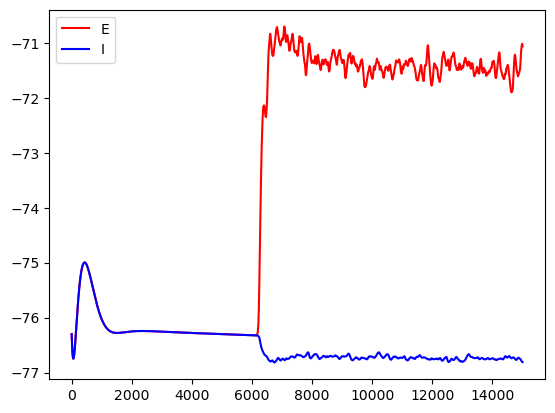

In [6]:
plt.plot(recvE0,'r',label='E')
plt.plot(recvI0,'b',label='I')
plt.legend()

Text(0.5, 1.0, 'active I')

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


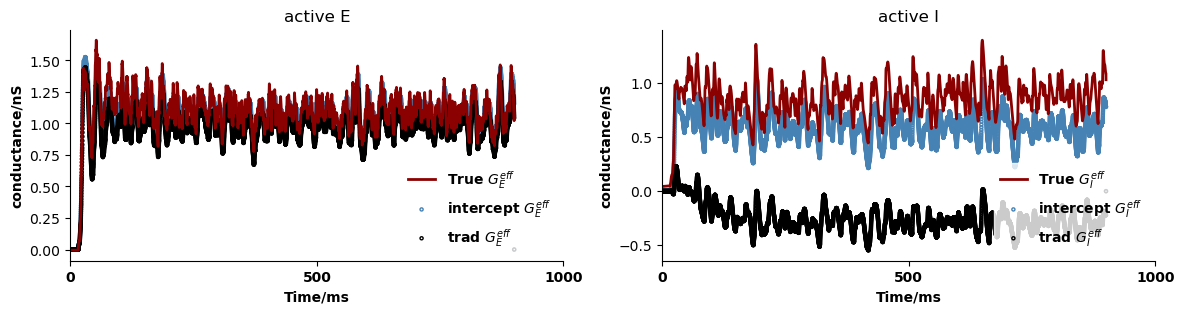

In [15]:
fig, ax2 = plt.subplots(1,2, figsize = (14,3))
plot_curve(ax2[0],np.arange(0,len(GE_est))*0.1, GE_est*1e6,color='darkred',label='True '+r'$G^{eff}_E$',
               xlim=[0,100], dx=50,
               ylim=[0, 2], dy=0., ynum_decimals=0, ylabel='conductance/nS')

plot_curve(ax2[0], np.arange(0,len(intercept_effective_conductance[0,:]))*0.1, 
           intercept_effective_conductance[0,:]*1e3, color='steelblue',label='intercept '+r'$G^{eff}_E$',
               xlim=[0,100], dx=50,
               ylim=[0, 2], dy=0., ynum_decimals=0, ylabel='conductance/nS',
               nonscatter=False, s0=5)

plot_curve(ax2[0], np.arange(0,len(traditional_effective_conductance[0,:]))*0.1, 
           traditional_effective_conductance[0,:]*1e3, color='black',label='trad '+r'$G^{eff}_E$',
               xlim=[0,1000], dx=500,
               ylim=[0, 2], dy  =0., ynum_decimals=1, ylabel='conductance/nS',
               nonscatter=False, s0=5)
ax2[0].set_title('active E')

plot_curve(ax2[1],np.arange(0,len(GE_est))*0.1, GI_est*1e6,color='darkred',label='True '+r'$G^{eff}_I$',
               xlim=[0,100], dx=50,
               ylim=[0, 2], dy=0., ynum_decimals=0, ylabel='conductance/nS')

plot_curve(ax2[1], np.arange(0,len(intercept_effective_conductance[0,:]))*0.1, 
           intercept_effective_conductance[1,:]*1e3,color='steelblue',label='intercept '+r'$G^{eff}_I$',
               xlim=[0,100], dx=50,
               ylim=[0, 2], dy=0., ynum_decimals=0, ylabel='conductance/nS',
               nonscatter=False, s0=5)

plot_curve(ax2[1], np.arange(0,len(traditional_effective_conductance[0,:]))*0.1, 
           traditional_effective_conductance[1,:]*1e3,color='black',label='trad '+r'$G^{eff}_I$',
               xlim=[0,1000], dx=500,
               ylim=[-0.1, 7], dy  =0., ynum_decimals=1, ylabel='conductance/nS',
               nonscatter=False, s0=5)
ax2[1].set_title('active I')

In [7]:
from matplotlib.ticker import FuncFormatter
def format_func(value, tick_number):
    return f'{value:.0f}'  # 将刻度值格式化为小数点后两位
def plot_curve(ax2,x,y,color='black',title='', linestyle='-',linewidth=2, xlim=[0,100],dx=20,
               ylim=[0,10],dy=5.0, fontsize=10, alpha = 1.0, xlabel='Time/ms', 
               ylabel = 'Frequency/Hz', label='',ynum_decimals =1, facecolors='none',
               nonscatter=True, s0=10, facecolor='none'):
    if nonscatter:
        if color:
            ax2.plot(x,y,color=color,linewidth=linewidth,linestyle=linestyle,alpha=alpha, label=label)
        else:
            ax2.plot(x,y,linewidth=linewidth,alpha=alpha, linestyle=linestyle,label=label)
    else:
        if color:
            ax2.scatter(x,y,edgecolors=color,facecolors = facecolor, alpha=alpha, 
                        label=label, s=s0)
        else:
            ax2.scatter(x,y, alpha=alpha, label=label,
                        s=s0)
        
    ax2.set_xlabel(xlabel,font2)
    ax2.set_ylabel(ylabel,font2)
    
    # def format_funcx(value, tick_number, num_decimals=xnum_decimals):
    #     if num_decimals==0:
    #         return f'{value:.0f}'
    #     return f'{value:.{num_decimals}f}'

    def format_funcy(value, tick_number, num_decimals=ynum_decimals):
        if num_decimals==0:
          return f'{value:.0f}'
        return f'{value:.{num_decimals}f}'

    # if dx:
    #     ax2.set_xticks(np.arange(xlim[0], xlim[1] + dx, dx))
    #     ax2.set_xticklabels(ax2.get_xticks(), fontsize=fontsize, weight='bold')
    #     ax2.set_xlim([xlim[0], xlim[1]])
        # ax2.xaxis.set_major_formatter(FuncFormatter(format_funcx))

    if dy:
        ax2.set_yticks(np.arange(ylim[0], ylim[1] + dy, dy))
        ax2.set_yticklabels(ax2.get_yticks(), fontsize=fontsize, weight='bold')
        ax2.set_ylim([ylim[0], ylim[1]])
        ax2.yaxis.set_major_formatter(FuncFormatter(format_funcy))
        
  
    if xlim:
       ax2.set_xticks(np.arange(xlim[0],xlim[1]+dx,dx))
       ax2.set_xticklabels(np.arange(xlim[0],xlim[1]+dx,dx),fontsize=10,weight='bold')
       ax2.set_xlim(xlim)
    # if ylim:
    #    ax2.set_yticks(np.arange(ylim[0],ylim[1]+dy,dy))
    #    ax2.set_yticklabels(np.arange(ylim[0],ylim[1]+dy,dy),fontsize=10,weight='bold')
    #    ax2.set_ylim(ylim)
    if title:
       ax2.set_title('{0}'.format(title),fontsize=12,weight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    if label:
       ax2.legend(loc='best',prop=font2,edgecolor='white')

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

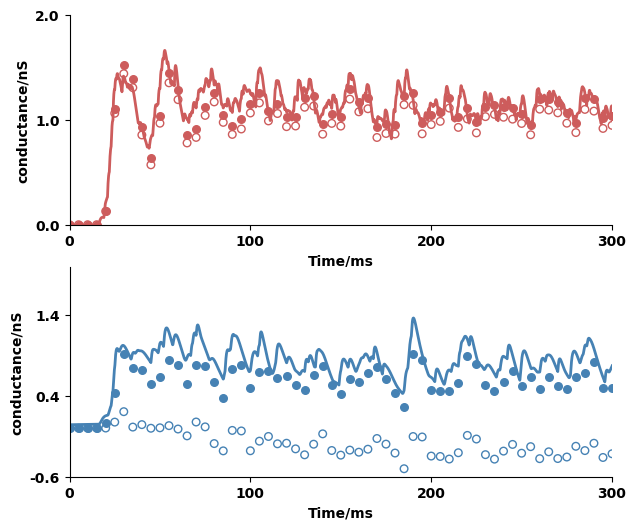

In [9]:
time = np.arange(0,len(GE_est))*0.1
s0 = 30
fig, ax2 = plt.subplots(2,1, figsize = (7,6))
plot_curve(ax2[0],time, GE_est*1e6, color='indianred', label='',
               xlim=[0,100], dx=50, linewidth=2, 
               ylim=[0, 2], dy=0., ynum_decimals=0, ylabel='conductance/nS')

plot_curve(ax2[0],time[::50], intercept_effective_conductance[0,::50]*1e3, color='indianred',label='',
               xlim=[0,100], dx=50,
               ylim=[0, 2], dy=0., ynum_decimals=0, ylabel='conductance/nS',
               nonscatter=False, s0=s0, facecolor='indianred')

plot_curve(ax2[0], time[::50], traditional_effective_conductance[0,::50]*1e3, color='indianred',label='',
               xlim=[0,300], dx=100,
               ylim=[0, 2], dy  = 1, ynum_decimals=1, ylabel='conductance/nS',
               nonscatter=False, s0=s0, facecolor='none')

plot_curve(ax2[1],time, GI_est*1e6,color='steelblue',label='',
               xlim=[0,100], dx=50,linewidth=2, 
               ylim=[0, 2], dy=0., ynum_decimals=0, ylabel='conductance/nS')

plot_curve(ax2[1], time[::50], 
           intercept_effective_conductance[1,::50]*1e3,color='steelblue',label='',
               xlim=[0,100], dx=50,
               ylim=[0, 2], dy=0., ynum_decimals=0, ylabel='conductance/nS',
               nonscatter=False, s0=s0, facecolor='steelblue')

plot_curve(ax2[1], time[::50], 
           traditional_effective_conductance[1,::50]*1e3,color='steelblue',label='',
               xlim=[0,300], dx=100, fontsize=10,
               ylim=[-0.6, 2], dy  =1., ynum_decimals=1, ylabel='conductance/nS',
               nonscatter=False, s0=s0, facecolor='none')
plt.savefig("/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/figure/figure4/mutipleEI_eff_con_twopanel_relative_reversal_potential10.eps", format='eps', dpi=300)
plt.show()

In [10]:
relative_error = np.zeros(4)
relative_error[0] = np.linalg.norm(GE_est*1e6-intercept_effective_conductance[0,:]*1e3)/np.linalg.norm(GE_est*1e6)
relative_error[1] = np.linalg.norm(GE_est*1e6-traditional_effective_conductance[0,:]*1e3)/np.linalg.norm(GE_est*1e6)
relative_error[2] = np.linalg.norm(GI_est*1e6-intercept_effective_conductance[1,:]*1e3)/np.linalg.norm(GI_est*1e6)
relative_error[3] = np.linalg.norm(GI_est*1e6-traditional_effective_conductance[1,:]*1e3)/np.linalg.norm(GI_est*1e6)
print(relative_error)

[0.07511676 0.13475929 0.32098155 1.28089664]


In [ ]:
locationE = ['dend','dend','dend','dend','dend','dend','dend','dend','dend','dend','dend','dend','dend','dend','dend']
locationI = ['apic','apic','apic','apic','apic']
locnumE0 = np.arange(1,5) + 40
locnumI0 = np.arange(1,5) + 50
locnumE = locnumE0*5
C=0.00024
GL = 1.93e-05
run_dt = 0.1 
fE = 1e-4
fI = 8*1e-4
# fre_stim =100
passive = False


# 然后继续创建您的模型和进行模拟
                     

L5PC = h.L5PCtemplate(morphologyFilename)

if passive:
    for sec in h.allsec():
        # 检查 section 是否有主动离子通道
        if h.ismembrane("na3", sec=sec):
            # 将电导设置为0
            sec.gbar_na3 = 0.
        if h.ismembrane("h", sec=sec):
            sec.ghdbar_h = 0.
        if h.ismembrane("kadist", sec=sec):
            sec.gkabar_kadist = 0.
        if h.ismembrane("kaprox", sec=sec):
            sec.gkabar_kaprox = 0.
        if h.ismembrane("kdrca1", sec=sec):
            sec.gkdrbar_kdrca1 = 0.
        if h.ismembrane("nax", sec=sec):
            sec.gbar_nax = 0.
        if h.ismembrane("Ca_HVA",sec=sec):
            sec.gCa_HVAbar_Ca_HVA = 0.
        if h.ismembrane("Ca_LVAst",sec=sec):
            sec.gCa_LVAstbar_Ca_LVAst = 0.
        if h.ismembrane("Ih",sec=sec):
            sec.gIhbar_Ih = 0.
        if h.ismembrane("Im",sec=sec):
            sec.gImbar_Im = 0.
        if h.ismembrane("K_Pst",sec=sec):
            sec.gK_Pstbar_K_Pst = 0.
        if h.ismembrane("K_Tst",sec=sec):
            sec.gK_Tstbar_K_Tst = 0.
        if h.ismembrane("Nap_Et2",sec=sec):
            sec.gNap_Et2bar_Nap_Et2 = 0.
        if h.ismembrane("NaTa_t",sec=sec):
            sec.gNaTa_tbar_NaTa_t = 0.
        if h.ismembrane("NaTs2_t",sec=sec):
            sec.gNaTs2_tbar_NaTs2_t = 0.
        if h.ismembrane("SK_E2",sec=sec):
            sec.gSK_E2bar_SK_E2 = 0.
        if h.ismembrane("SKv3_1",sec=sec):
            sec.gSKv3_1bar_SKv3_1 = 0.   
    
h.dt = run_dt
h.tstop = 400.
if passive:
    h.v_init = -90.
    Vclamp_init = -90.
else:
    h.v_init = -76.4
    Vclamp_init = -76.4
recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)

# Initialize an excitatory and inhibitory synaptic input
# make a new stimulator
stimEs =[]
synEs = []
ncstimEs = []
stimIs =[]
synIs = []
ncstimIs = []

for i in range(len(locnumE)):
    stimE = h.NetStim()
    stimE.number = 1
    stimE.start = Estart[i]  # ms
    stimE.noise = 1
    # rs = h.Random()
    # rs.Random123(i,i+1,i+2)
    # rs.negexp(1)
    # stimE.noiseFromRandom(rs)
    if locationE[i] == 'dend':
        synE = h.Exp2Syn(L5PC.dend[int(locnumE[i])](0.5))
    if locationE[i] == 'apic':
        synE = h.Exp2Syn(L5PC.apic[int(locnumE[i])](0.5))
    if locationE[i] == 'soma':
        synE = h.Exp2Syn(L5PC.soma[0](0.5))
    synE.tau1 = 5.  # ms
    synE.tau2 = 8.  # ms
    synE.e = 0.  # mV for E input and -100 for I input 
    ncstimE = h.NetCon(stimE, synE)
    ncstimE.delay = 0.
    ncstimE.weight[0] = 0e-2  # uS
    stimEs.append(stimE)
    synEs.append(synE)
    ncstimEs.append(ncstimE)

#print spike times coming from ns
def pr():
  print (h.t)
ncstimEs[0].record(pr)
    

# for i in range(len(locnumI)):
#     stimI = h.NetStim()
#     stimI.number = int(fre_stim)
#     stimI.start = Istart[i]
#     if locationI[i] == 'dend':
#         synI = h.Exp2Syn(L5PC.dend[int(locnumI[i])](0.5))
#     if locationI[i] == 'apic':
#         synI = h.Exp2Syn(L5PC.apic[int(locnumI[i])](0.5))
#     if locationI[i] == 'soma':
#         synI = h.Exp2Syn(L5PC.soma[0](0.5))
#     synI.tau1 = 6.  # ms
#     synI.tau2 = 18.  # ms
#     synI.e = -100.
#     ncstimI = h.NetCon(stimI, synI)
#     ncstimI.delay = 0.
#     ncstimI.weight[0] = 0e-2  # uS
#     stimIs.append(stimI)
#     synIs.append(synI)
#     ncstimIs.append(ncstimI)

i_loc =h.Vector().record(synEs[0]._ref_i)
i_loc1 =h.Vector().record(synEs[1]._ref_i)


# Initialize voltage clamp
vclamp = h.SEClamp(L5PC.soma[0](0.5))
vclamp.amp1 = Vclamp_init
vclamp.dur1 = h.tstop
vclamp.dur2 = h.tstop
vclamp.amp2 = Vclamp_init - 20.

irec = h.Vector()
irec.record(vclamp._ref_i)

# Function to initialize the simulation
def initialize():
    h.t = 0
    h.finitialize(h.v_init)
    h.fcurrent()

# Function to integrate the simulation
def integrate():
    while h.t < h.tstop:
        h.fadvance()

# Function to run the simulation
def go():
    initialize()
    integrate()

V_rest = -76.4
epsilonE = 0. - V_rest
epsilonI = -100. - V_rest
epsilonI1 = -120. - V_rest

#  pure E input for the estimation of GE
for i in range(len(locnumE)):
    ncstimEs[i].weight[0] = fE
    synEs[i].e = 0.
# for i in range(len(locnumI)):
#     ncstimIs[i].weight[0] = 0.
#     synIs[i].e = -100.
vclamp.dur1 = 0.
vclamp.dur2 = 0.
vclamp.dur3 = 0.
go()
recvE0 = np.array(recv.to_python())
recvE0_norm = recvE0 - V_rest
dVdtE = np.diff(recvE0_norm)/run_dt
dVdtE = np.append(dVdtE, 0)
GE_est = (C*dVdtE + GL*recvE0_norm)/(epsilonE - recvE0_norm)
i_loc_pureE = np.array(i_loc.to_python())
i_loc10 = np.array(i_loc1.to_python())
# plt.plot(i_loc0, 'k',label='pure E')



# #  pure I input for estimation of GI
# for i in range(len(locnumE)):
#     ncstimEs[i].weight[0] = 0.
#     synEs[i].e = 0.
# for i in range(len(locnumI)):
#     ncstimIs[i].weight[0] = fI
#     synIs[i].e = -100.
# vclamp.dur1 = 0.
# vclamp.dur2 = 0.
# vclamp.dur3 = 0.
# go()
# recvI0 = np.array(recv.to_python())
# i_loc0 = np.array(i_loc.to_python())
# recvI0_norm = recvI0 - V_rest
# dVdtI = np.diff(recvI0_norm)/run_dt
# dVdtI = np.append(dVdtI, 0)
# GI_est = (C*dVdtI + GL*recvI0_norm)/(epsilonI - recvI0_norm)


# Vclamp = np.arange(-110.,-60.,10)
# Isyn_inj_t = np.zeros((len(Vclamp),len(i_loc0)))
# Isyn_epsilonI1_inj_t = np.zeros((len(Vclamp),len(i_loc0)))
# # tstart = int(stimEs[0].start/run_dt+1)


#  pure E input for test of repetition
for i in range(len(locnumE)):
    ncstimEs[i].weight[0] = fE
    synEs[i].e = 0.
# for i in range(len(locnumI)):
#     ncstimIs[i].weight[0] = 0.
#     synIs[i].e = -100.
vclamp.dur1 = 0.
vclamp.dur2 = 0.
vclamp.dur3 = 0.
go()
recvE01 = np.array(recv.to_python())
recvE01_norm = recvE01 - V_rest
dVdtE = np.diff(recvE01_norm)/run_dt
dVdtE = np.append(dVdtE, 0)
GE_est1 = (C*dVdtE + GL*recvE01_norm)/(epsilonE - recvE01_norm)
i_loc_pureE1 = np.array(i_loc.to_python())
i_loc12 = np.array(i_loc1.to_python())
# plt.plot(i_loc0, 'k',label='pure E')


# for i in range(len(Vclamp)):
#     vclamp.amp1 = Vclamp[i]
#     vclamp.dur1 = h.tstop
#     h.v_init = V_rest
#     # no E and I, caculate I0 under voltage clamp
#     for j in range(len(locnumE)):
#         ncstimEs[j].weight[0] = 0.
#         synEs[j].e = 0.
#     for j in range(len(locnumI)):
#         ncstimIs[j].weight[0] = 0.
#         synIs[j].e = -100.
#     go()
#     Iinj0 = np.array(irec.to_python())  # Assuming irec is a NEURON Vector
#     i_loc0 = np.array(i_loc.to_python())

#     # given E and I, caculate I1 under voltage clamp
#     for j in range(len(locnumE)):
#         ncstimEs[j].weight[0] = fE
#     for j in range(len(locnumI)):
#         ncstimIs[j].weight[0] = fI
#     vclamp.amp1 = Vclamp[i]
#     vclamp.dur1 = h.tstop
#     h.v_init = V_rest
#     go()
#     i_loc0 = np.array(i_loc.to_python())
#     plt.plot(i_loc0, label='E,I voltage clamp')
#     Iinj1 = np.array(irec.to_python())  # Assuming irec is a NEURON Vector
#     Isyn = (Iinj1 - Iinj0)
#     Isyn_inj_t[i,:] = Isyn


#     # change epsilonI to epsilonI1
#     for j in range(len(locnumI)):
#         synIs[j].e = -120.
#         ncstimIs[j].weight[0] = fI
#     for j in range(len(locnumE)):
#         ncstimEs[j].weight[0] = fE  
            
#     vclamp.amp1 = Vclamp[i]
#     vclamp.dur1 = h.tstop
#     h.v_init = V_rest
#     go()
#     Iinj1_epsilonI1 = np.array(irec.to_python())  # Assuming irec is a NEURON Vector
#     Isyn_epsilonI1 =  (Iinj1_epsilonI1 - Iinj0)
#     Isyn_epsilonI1_inj_t[i,:] = Isyn_epsilonI1

                                                    
# traditional_effective_conductance = np.zeros((2,len(i_loc0)))
# intercept_effective_conductance = np.zeros((2,len(i_loc0)))
# A = np.ones((len(Vclamp),2))
# A[:,0] = Vclamp - V_rest
# for i in range(len(i_loc0)):
#     x, residuals, rank, singular_values = np.linalg.lstsq(A, Isyn_inj_t[:,i], 
#                                                             rcond=None)
#     x_epsilonI1, residuals, rank, singular_values = np.linalg.lstsq(A, 
#                         Isyn_epsilonI1_inj_t[:,i], rcond=None)
    
#     traditional_effective_conductance[1, i] = (x[0]*epsilonE + x[1])/(epsilonE - epsilonI)
#     traditional_effective_conductance[0, i] = (x[0]*epsilonI + x[1])/(epsilonI - epsilonE)
    
#     intercept_effective_conductance[1,i] = (x[1] - x_epsilonI1[1])/(epsilonI1 - epsilonI)
#     intercept_effective_conductance[0,i] = (-intercept_effective_conductance[1,i]*epsilonI - x[1])/epsilonE

: 

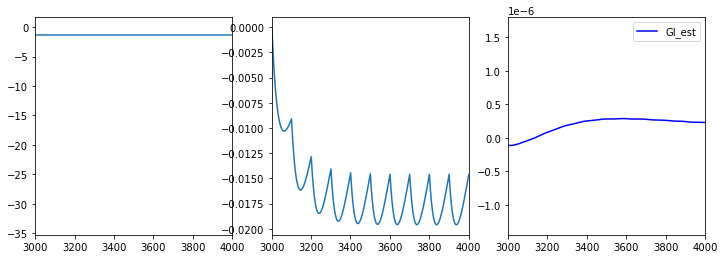

In [40]:
fig, ax2 = plt.subplots(1,3, figsize=(12,4))
ax2[0].plot(Iinj0)
ax2[1].plot(i_loc0)
ax2[1].set_xlim([3000,4000])
ax2[0].set_xlim([3000,4000])
# ax2[2].plot(GE_est,'r',label = 'GE_est')
ax2[2].plot(GI_est,'b',label = 'GI_est')
ax2[2].set_xlim([3000,4000])
ax2[2].legend()